# 클러스터링을 활용하여 고객의 행동을 예측해보자!

In [1]:
# 데이터 불러오기

In [2]:
import pandas as pd

uselog = pd.read_csv('use_log.csv')
uselog.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [3]:
# end_date의 결측치를 제외하고는 그 외의 컬럼에서는 결측치가 없음을 확인했다.

customer = pd.read_csv('customer_join.csv')
customer.isnull().sum()
customer.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaN,CA1,0,2_야간,6000,2_일반,3.916667,4.0,6,1,1,2019-04-30,47


In [4]:
customer.columns

Index(['customer_id', 'name', 'class', 'gender', 'start_date', 'end_date',
       'campaign_id', 'is_deleted', 'class_name', 'price', 'campaign_name',
       'mean', 'median', 'max', 'min', 'routine_flg', 'calc_date',
       'membership_period'],
      dtype='object')

In [5]:
# 이용이력을 활용하여 예측을 진행하기에 지도학습이 아닌 비지도학습인 클러스트링을 진해
# 클러스터링에 필요한 컬럼들을 추출하기

customer_clustering = customer[['mean', 'median', 'max', 'min', 'membership_period']]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [6]:
# 전자는 월 이용횟수이기 때문에 1~8 사이의 값을 가지지만 멤버십 이용 기간은 최대 47까지 있기 때문에 스케일링을 진행하여 값을 비슷한 크기로 맞춰주어야한다.

In [7]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

customer_clustering_sc

# 표준 정규화를 통해 값을 일정한 값들로 변환해주었다.

array([[-0.28120614, -0.13367635,  0.08117747, -0.5336197 ,  2.03402524],
       [-0.14054502, -0.13367635, -0.37992814, -0.02114919,  2.03402524],
       [-0.42186727, -0.13367635, -0.84103375, -0.02114919,  2.03402524],
       ...,
       [ 1.50050144,  1.46662237,  0.08117747,  2.54120338, -1.28811491],
       [ 3.18843493,  3.06692109,  1.46449428,  4.07861492, -1.28811491],
       [ 2.62579043,  2.53348819,  1.00338868,  3.56614441, -1.28811491]])

In [8]:
# 변수들간의 거리를 계산하여 예측을 진행하는 kmeans clustering을 진행해보자.
kmeans = KMeans(n_clusters = 4, random_state = 2024)
cluster = kmeans.fit(customer_clustering_sc)
print(cluster.labels_)   # 각 행의 클러스터링을 진행하고 어떠한 군집에 속한지 확인
customer_clustering['cluster'] = cluster.labels_
print(customer_clustering['cluster'].unique()) # 군집의 유형 파악
customer_clustering.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 1 1 ... 0 0 0]
[1 2 3 0]


<ipython-input-8-f8ad939f9a9f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_clustering['cluster'] = cluster.labels_


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,1
1,5.083333,5.0,7,3,47,1
2,4.583333,5.0,6,3,47,1
3,4.833333,4.5,7,2,47,1
4,3.916667,4.0,6,1,47,1


In [9]:
# 컬럼을 보기 쉽게 컬럼의 이름들을 변경해주자

customer_clustering.columns = ['월평균값','월중앙값', '월최댓값', '월최솟값', '회원기간', 'cluster']
customer_clustering.groupby('cluster').count()

# 3번 그룹의 수가 제일 많음을 알 수 있다.

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,838,838,838,838,838
1,1249,1249,1249,1249,1249
2,771,771,771,771,771
3,1334,1334,1334,1334,1334


In [10]:
# 클러스터링 결과를 시각화해보자

from sklearn.decomposition import PCA
X = customer_clustering_sc
pca = PCA(n_components = 2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df['cluster'] = customer_clustering['cluster']

# 주성분분석을 통해 2차원으로 축소하여 결과를 나타내었다.

In [11]:
pca_df

,0,1,cluster
0,-0.819982,-1.959097,1
1,-0.707922,-1.799857,1
2,-1.061499,-1.659826,1
3,-1.160764,-1.810139,1
4,-2.017132,-1.670101,1
...,...,...,...
4187,3.027933,1.139635,0
4188,5.064720,0.769684,0
4189,3.027933,1.139635,0
4190,6.083114,0.584708,0


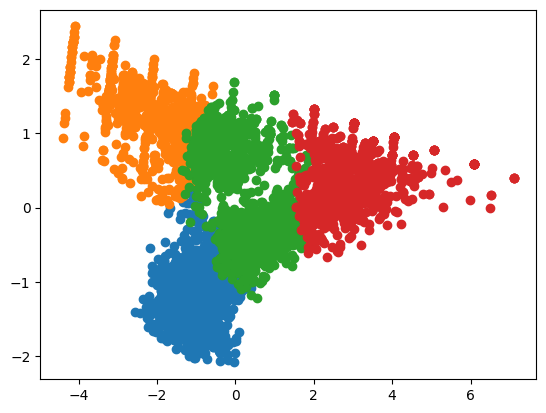

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in customer_clustering['cluster'].unique():
  tmp = pca_df.loc[pca_df['cluster'] == i]
  plt.scatter(tmp[0], tmp[1])

In [13]:
# 클러스터링 결과를 바탕으로 탈퇴회원의 경향을 파악하자.

customer_clustering = pd.concat([customer_clustering, customer], axis = 1)
customer_clustering

,월평균값,월중앙값,월최댓값,월최솟값,회원기간,cluster,customer_id,name,class,gender,...,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,4.833333,5.0,8,2,47,1,OA832399,XXXX,C01,F,...,0_종일,10500,2_일반,4.833333,5.0,8,2,1,2019-04-30,47
1,5.083333,5.0,7,3,47,1,PL270116,XXXXX,C01,M,...,0_종일,10500,2_일반,5.083333,5.0,7,3,1,2019-04-30,47
2,4.583333,5.0,6,3,47,1,OA974876,XXXXX,C01,M,...,0_종일,10500,2_일반,4.583333,5.0,6,3,1,2019-04-30,47
3,4.833333,4.5,7,2,47,1,HD024127,XXXXX,C01,F,...,0_종일,10500,2_일반,4.833333,4.5,7,2,1,2019-04-30,47
4,3.916667,4.0,6,1,47,1,HD661448,XXXXX,C03,F,...,2_야간,6000,2_일반,3.916667,4.0,6,1,1,2019-04-30,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4187,8.000000,8.0,8,8,1,0,HD676663,XXXX,C01,M,...,0_종일,10500,2_일반,8.000000,8.0,8,8,0,2019-04-30,1
4188,10.000000,10.0,10,10,1,0,HD246549,XXXXX,C01,F,...,0_종일,10500,2_일반,10.000000,10.0,10,10,0,2019-04-30,1
4189,8.000000,8.0,8,8,1,0,GD037007,XXXXX,C03,M,...,2_야간,6000,2_일반,8.000000,8.0,8,8,0,2019-04-30,1
4190,11.000000,11.0,11,11,1,0,OA953150,XXXXX,C01,M,...,0_종일,10500,2_일반,11.000000,11.0,11,11,0,2019-04-30,1


In [14]:
customer_clustering.groupby(['cluster', 'is_deleted'], as_index = False).count()[['cluster','is_deleted','customer_id']]

# 2번 그룹은 탈퇴회원만 있음을 알 수 있다.

,cluster,is_deleted,customer_id
0,0,0,820
1,0,1,18
2,1,0,1231
3,1,1,18
4,2,1,771
5,3,0,791
6,3,1,543


In [15]:
# 정기적/비정기적 이용 여부를 살펴보자.

customer_clustering.groupby(['cluster', 'routine_flg'], as_index = False).count()[['cluster', 'routine_flg', 'customer_id']]

,cluster,routine_flg,customer_id
0,0,0,51
1,0,1,787
2,1,0,2
3,1,1,1247
4,2,0,499
5,2,1,272
6,3,0,227
7,3,1,1107


In [14]:
# 다음 달의 이용 횟수를 예측해보자.

In [20]:
uselog['usedate'] = pd.to_datetime(uselog['usedate'])
uselog['연월'] = uselog['usedate'].dt.strftime('%Y%m')
uselog_months = uselog.groupby(['연월', 'customer_id'],as_index = False).count()
uselog_months.rename(columns = {'log_id' : 'count'}, inplace = True)
del uselog_months['usedate']
uselog_months.head()

,연월,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [25]:
years_month = list(uselog_months['연월'].unique())
predict_data = pd.DataFrame()
for i in range(6, len(years_month)): # 10월부터 3월까지의 데이터를 확인하기 위해 6부터 시작
  tmp = uselog_months.loc[uselog_months['연월'] == years_month[i]]
  tmp.rename(columns = {"count" : "count_pred"}, inplace = True)
  for j in range(1, 7):
    tmp_before = uselog_months.loc[uselog_months['연월']==years_month[i-j]]
    del tmp_before['연월']
    tmp_before.rename(columns = {"count" : "count_{}".format(j-1)}, inplace = True)
    tmp = pd.merge(tmp, tmp_before, on = 'customer_id', how = 'left')
  predict_data = pd.concat([predict_data, tmp], ignore_index = True)
predict_data.head()


# count_pred 는 예측하고자하는 달의 횟수를 의미한다.
# count_pred가 정답이고 count_{}가 학습을 시킬 변수들이 된다.

<ipython-input-25-447d68d7380d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.rename(columns = {"count" : "count_pred"}, inplace = True)
<ipython-input-25-447d68d7380d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_before.rename(columns = {"count" : "count_{}".format(j-1)}, inplace = True)
<ipython-input-25-447d68d7380d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_before.rename(columns = {"count" : "count_{}".for

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


In [26]:
print(years_month)

['201804', '201805', '201806', '201807', '201808', '201809', '201810', '201811', '201812', '201901', '201902', '201903']


In [27]:
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop = True)
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


In [30]:
# 특징이 되는 변수들을 추가해보자.

predict_data = pd.merge(predict_data, customer[['customer_id', 'start_date']], on = 'customer_id', how = 'left')
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [32]:
# 회원기간과 연월의 차이를 활용하여 회원 기간을 월 단위로 작성해보자

predict_data['now_date'] = pd.to_datetime(predict_data['연월'], format ='%Y%m')
predict_data['start_date']= pd.to_datetime(predict_data['start_date'])
from dateutil.relativedelta import relativedelta
predict_data['period'] = None
for i in range(len(predict_data)):
  delta = relativedelta(predict_data['now_date'][i], predict_data['start_date'][i])
  predict_data['period'][i] = delta.years*12 + delta.months
predict_data.head()

<ipython-input-32-e87f7ac1d07d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['period'][i] = delta.years*12 + delta.months


,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


In [34]:
# 다음 달 이용 횟수를 예측하는 모델을 구축하자
# 예측하고자하는 변수가 연속형이기 때문에 선형 회귀 모델을 사용할 예정

predict_data = predict_data.loc[predict_data['start_date'] >= pd.to_datetime("20180401")]
from sklearn import linear_model
import sklearn.model_selection
model = linear_model.LinearRegression()
X = predict_data[['count_0', 'count_1', 'count_2', 'count_3', 'count_4', 'count_5', 'period']]
y = predict_data['count_pred']

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)
model.fit(X_train, y_train)

LinearRegression()

In [35]:
# 정확도를 검증해보자

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.6079057548291972
0.6067577445482485


In [37]:
# 모델에 기여하는 변수를 확인하자

coef = pd.DataFrame({"features_names" : X.columns, "coefficient":model.coef_})
coef

,features_names,coefficient
0,count_0,0.326653
1,count_1,0.205535
2,count_2,0.164373
3,count_3,0.185541
4,count_4,0.079875
5,count_5,0.038769
6,period,0.048749


In [49]:
# 다음달의 이용횟수를 예측해보자

X1 = [3,4,4,6,8,7,8]
X2 = [2,2,3,3,4,6,8]
x_pred = [X1, X2]

In [50]:
model.predict(x_pred)

# 이용횟수가 1번과 같다면 다음 달에 대략 4번 정도 방문할 것으로 예측을 하며
# 이용횟수가 2번과 같다면 다음 달에 대략 2번 정도 방문할 것으로 예측하는 모델을 만들게 되었다!

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([3.83397593, 2.01698792])

In [55]:
uselog_months.to_csv('use_log_months.csv', index = False)